In [38]:
#Imports
from sympy import *
import pandas as pd
import numpy as np
from text_unidecode import unidecode
from forex_python.converter import CurrencyRates
import locale
from re import sub
from decimal import Decimal
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import missingno as mno

curr_rates = CurrencyRates()

In [47]:
# Initial cleanup
#1. Reading the data from the csv file and dropping unwanted columns
airbnb_listings = pd.read_csv("listings.csv");
columns_to_keep = [
    'id',
    'name',
    'host_id',
    'host_name',
    'neighbourhood_cleansed',
    'latitude',
    'longitude',
    'room_type',
    'price',
    'minimum_nights',
    'number_of_reviews',
    'last_review',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]
airbnb_listings = airbnb_listings[columns_to_keep]

In [48]:
#2.
s1 = airbnb_listings.shape[0]
#remove rows where number_of_reviews is 0
airbnb_listings = airbnb_listings[airbnb_listings['number_of_reviews'] != 0]
#remove rows with missing values
airbnb_listings = airbnb_listings.dropna()
s2 = airbnb_listings.shape[0]

s1 - s2 #number of rows removed

1689

In [50]:
#3.
#Cleaning up the neighbourhood_cleansed feature:  
#change 'Nrrebro' to 'Nørrebro'
airbnb_listings['neighbourhood_cleansed'] = airbnb_listings['neighbourhood_cleansed'].replace('Nrrebro', 'Nørrebro')
#change 'sterbro' to 'Østerbro'
airbnb_listings['neighbourhood_cleansed'] = airbnb_listings['neighbourhood_cleansed'].replace('sterbro', 'Østerbro')
#change 'Brnjshj-Husum' to 'Brønshøj-Husum'
airbnb_listings['neighbourhood_cleansed'] = airbnb_listings['neighbourhood_cleansed'].replace('Brnjshj-Husum', 'Brønshøj-Husum')
#change 'Vanserbro' to 'Vanløse'
airbnb_listings['neighbourhood_cleansed'] = airbnb_listings['neighbourhood_cleansed'].replace('Vanserbro', 'Vanløse')
#change 'Amager st' to 'Amager Øst'
airbnb_listings['neighbourhood_cleansed'] = airbnb_listings['neighbourhood_cleansed'].replace('Amager st', 'Amager Øst')
airbnb_listings['neighbourhood_cleansed'].unique()

#modify the price feature:
#if the price is a string and contains '$'
if airbnb_listings['price'].dtype == 'object' and airbnb_listings['price'].str.contains('$').any():
    #remove '$' and ',' and convert to float and round to 2 decimals
    airbnb_listings['price'] = (airbnb_listings['price'].str.replace('$', '').str.replace(',', '').astype(float) * curr_rates.get_rate('USD', 'DKK')).round(2)

airbnb_listings['price'].head()

0    1699.67
1    4921.10
2    6151.37
3    1372.23
4    3698.39
Name: price, dtype: float64

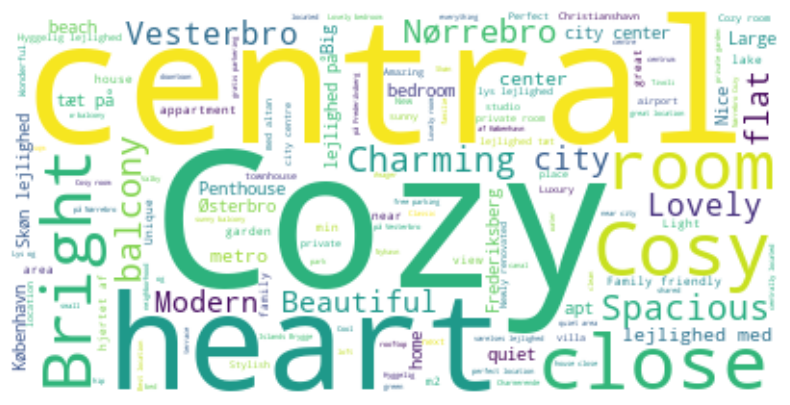

In [51]:
#4. word cloud on the 'name' column
text = " ".join(i for i in airbnb_listings.name)
stopwords = ["Copenhagen", "CPH", "apartment"] + list(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#5. Host names word cloud
text = " ".join(str(i) for i in airbnb_listings.host_name)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(text)
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='antialiased')
plt.axis("off")
plt.show()
# it seems to mostly conform to the distribution on Danmarks Statistik, especially for female names

In [52]:
#6.
#create 11 evenly spaced bins for price with the last bin being 10,000-inf using np.linspace
bins = np.linspace(0, 10000, 11)
#use digitize to bin the price column
airbnb_listings['price_bin'] = np.digitize(airbnb_listings['price'], bins)

#check:
airbnb_listings[['price', 'price_bin']].head()
# show distinct price bins and order them
airbnb_listings['price_bin'].sort_values().unique()
#print 1 price and price_bin for each unique price_bin
airbnb_listings[['price', 'price_bin']].drop_duplicates(subset='price_bin', keep='first').sort_values('price_bin')

,price,price_bin
12,880.12,1
0,1699.67,2
5,2422.69,3
4,3698.39,4
1,4921.10,5
8,5519.20,6
2,6151.37,7
52,7570.92,8
120,8994.25,9
531,9842.19,10


In [ ]:
#7.Plotting it on a map
# Creating a map centered around the average latitude and longitude
m = folium.Map(location=[airbnb_listings['latitude'].mean(), airbnb_listings['longitude'].mean()], zoom_start=12)

# Defining colors for price bins
colors = ['blue', 'green', 'orange', 'red', 'purple', 'pink', 'brown', 'gray', 'black', 'yellow', 'cyan','teal']

for i in range(len(airbnb_listings)):
    latitude = airbnb_listings.get('latitude')[i]
    longitude = airbnb_listings.get('longitude')[i]
    price_bin = airbnb_listings.get('price_bin')[i]
    price = airbnb_listings.get('price')[i]
    if latitude is not None and longitude is not None and price_bin is not None:
        folium.CircleMarker(
            location=[latitude, longitude],
            radius=5,
            color=colors[int(price_bin)],
            fill=True,
            fill_color=colors[int(price_bin)],
            fill_opacity=0.7,
            popup=price,
        ).add_to(m)
m 

In [ ]:
#7. Grouping by neighbourhood  
m = folium.Map(location=[airbnb_listings['latitude'].mean(), airbnb_listings['longitude'].mean()], zoom_start=12)    
colors = ['blue', 'green', 'orange', 'red', 'purple', 'pink', 'brown', 'gray', 'black', 'cyan', 'teal','pink']
all_neighbourhoods = airbnb_listings.get('neighbourhood_cleansed').unique()
neighbourhood_color_mapping = dict(zip(all_neighbourhoods, colors))

for i in range(len(airbnb_listings)):
    latitude = airbnb_listings.get('latitude')[i]
    longitude = airbnb_listings.get('longitude')[i]
    neighbourhood = airbnb_listings.get('neighbourhood_cleansed')[i]
    price_bin = airbnb_listings.get('price_bin')[i]
    popup_text = neighbourhood + "\nPrice: " + str(airbnb_listings.get('price')[i])
    if latitude is not None and longitude is not None and price_bin is not None:
        folium.CircleMarker(
            location=[latitude, longitude],
            radius=5,
            color=neighbourhood_color_mapping.get(neighbourhood),
            fill=True,
            fill_color=colors[int(price_bin)],
            fill_opacity=0.7,
            popup=popup_text,
        ).add_to(m)
print(neighbourhood_color_mapping)
m

In [ ]:
#8. Box plotting by neighbourhood and price
plt.figure(figsize=(10, 6))
sns.boxplot(data=airbnb_listings, x='neighbourhood_cleansed', y='price')
plt.title('Price Distribution by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.ylim(0, 20000)
plt.show()

# This shows that half of the listings in each neighbourhood revolve around the same price as in other neighbourhoods

In [ ]:
# Box plotting by neighbourhood and number of reviews
plt.figure(figsize=(10, 6))
sns.boxplot(data=airbnb_listings, x='neighbourhood_cleansed', y='number_of_reviews')
plt.title('Review Distribution by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()


In [ ]:
 #Box plotting by neighbourhood and minimum nights
plt.figure(figsize=(10, 6))
sns.boxplot(data=airbnb_listings, x='neighbourhood_cleansed', y='minimum_nights')
plt.title('Minimum Nights by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Minimum Nights')
plt.xticks(rotation=90)
plt.show()

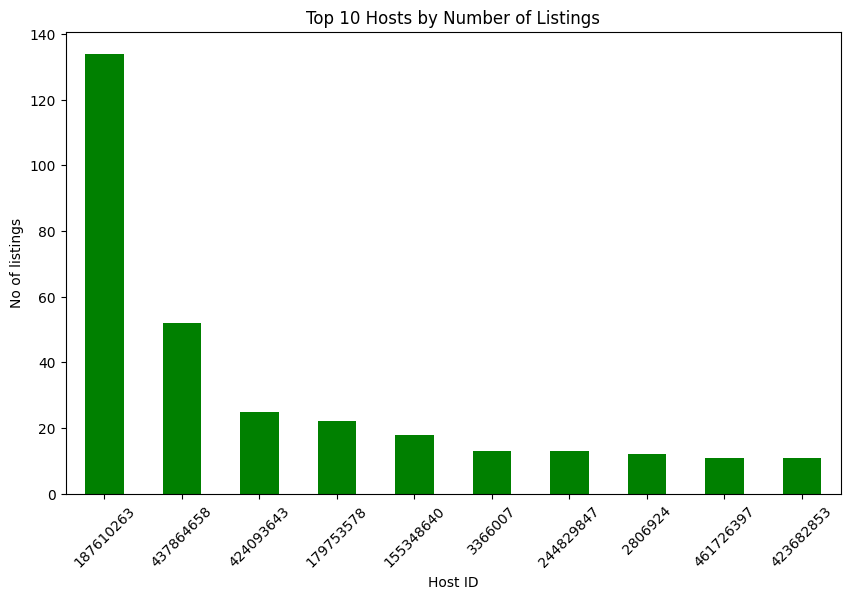

In [53]:
#9. Bar chart of hosts with top ten listings
hosts = airbnb_listings['host_id'].value_counts().head(10)
plt.figure(figsize=(10, 6))
hosts.plot(kind='bar', color='green')
plt.xlabel('Host ID')
plt.ylabel('No of listings')
plt.title('Top 10 Hosts by Number of Listings')
plt.xticks(rotation=45) 
plt.show()

In [ ]:
#10. Statistics by neighbourhood
stats = airbnb_listings.groupby(['neighbourhood_cleansed', 'room_type', 'number_of_reviews', 'minimum_nights'])['price'].agg(
    mean='mean',
    mode=lambda x: x.mode().iat[0] if not x.empty else None,
    median='median',
    std='std',
    min='min',
    max='max',
    q25=lambda x: x.quantile(0.25),
    q75=lambda x: x.quantile(0.75)
).reset_index()

stats.head(50)

In [54]:
#11. Top ten highest rating listings + map
m = folium.Map(location=[airbnb_listings['latitude'].mean(), airbnb_listings['longitude'].mean()], zoom_start=12)    
top_ten = airbnb_listings.nlargest(10, 'review_scores_rating')

for i in range(len(top_ten)):
    latitude = airbnb_listings.get('latitude')[i]
    longitude = airbnb_listings.get('longitude')[i]
    popup_text = "Review score:\n" + str(airbnb_listings.get('review_scores_rating')[i])
    if latitude is not None and longitude is not None and price_bin is not None:
        folium.Marker(
            location=[latitude, longitude],
            radius=5,
            color='blue',
            popup=popup_text,
        ).add_to(m)
m

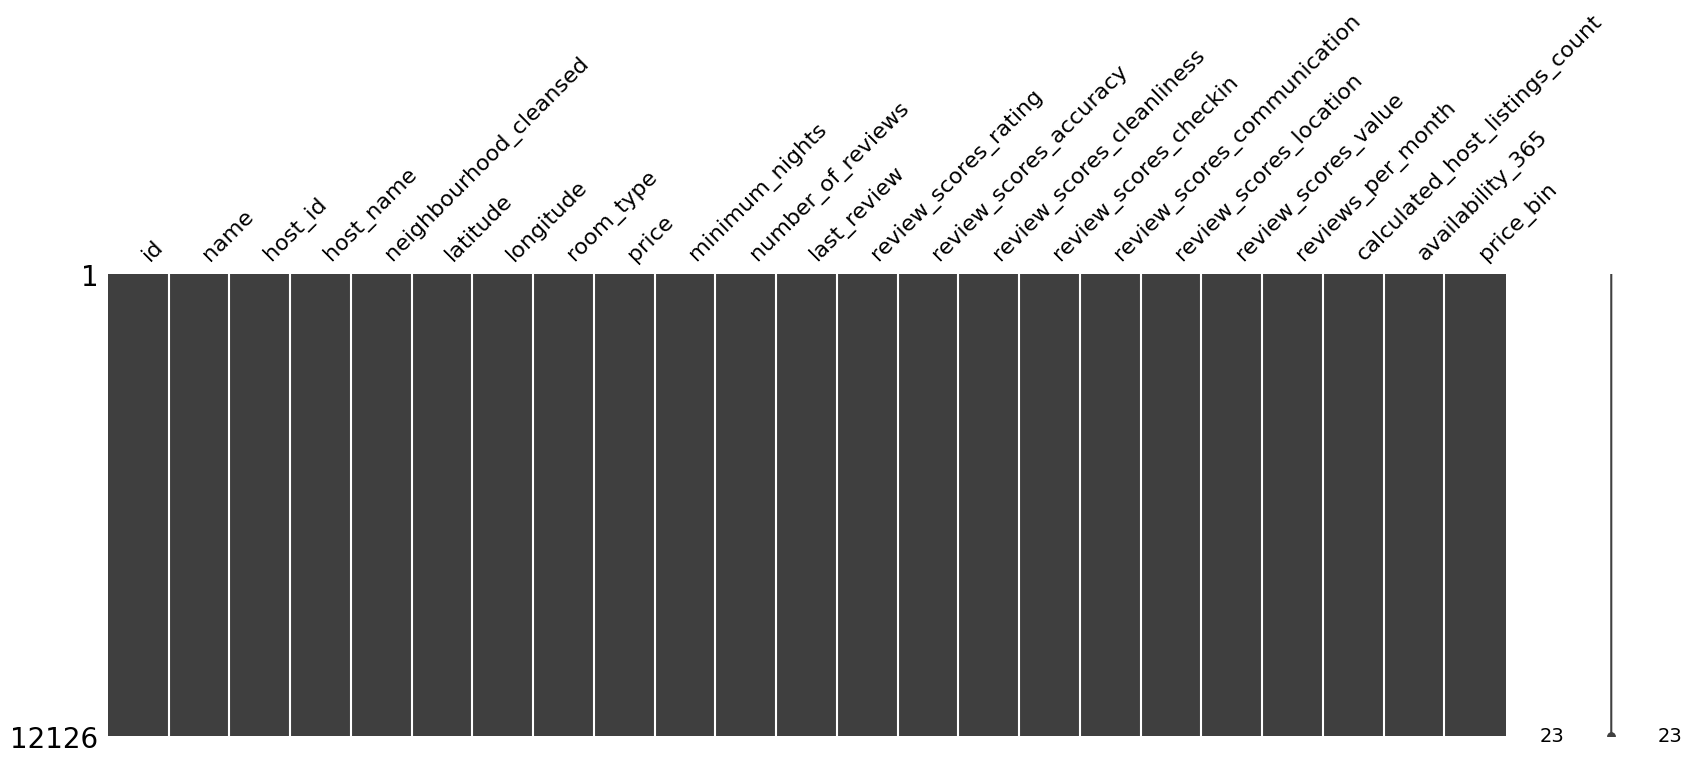

In [55]:
#12.Feature engineering
# airbnb_listings.info()
airbnb_listings.describe()
mno.matrix(airbnb_listings, figsize = (20, 6))

#Creating dummy varibales for room type and neighbourhoods and dropping
airbnb_listings = pd.get_dummies(airbnb_listings, columns=['room_type', 'neighbourhood_cleansed'])

In [56]:
#13. Add price category and encode as expensive or affordable
#add column IsExpensive which is 1 if price is above median price and 0 if price is below or equal to median price
airbnb_listings['IsExpensive'] = np.where(airbnb_listings['price'] > airbnb_listings['price'].median(), 1, 0)
airbnb_listings[['price', 'IsExpensive']].head(), airbnb_listings['price'].median()

(     price  IsExpensive
 0  1699.67            0
 1  4921.10            1
 2  6151.37            1
 3  1372.23            0
 4  3698.39            1,
 1852.98)

In [57]:
#14.
#split data into train and test
X = airbnb_listings[['review_scores_rating', 'reviews_per_month', 'minimum_nights', 'availability_365', 'price_bin']]
#X = airbnb_listings[['review_scores_rating', 'reviews_per_month', 'minimum_nights', 'availability_365', 'neighbourhood_cleansed_Amager Vest', 'neighbourhood_cleansed_Amager st', 'neighbourhood_cleansed_Bispebjerg', 'neighbourhood_cleansed_Brnshj-Husum', 'neighbourhood_cleansed_Indre By', 'neighbourhood_cleansed_Nørrebro', 'neighbourhood_cleansed_Valby', 'neighbourhood_cleansed_Vanlse', 'neighbourhood_cleansed_Vesterbro-Kongens Enghave', 'neighbourhood_cleansed_Østerbro', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room']]
#X = airbnb_listings[['review_scores_rating', 'reviews_per_month', 'minimum_nights', 'availability_365', 'neighbourhood_cleansed_Amager Vest', 'neighbourhood_cleansed_Amager st', 'neighbourhood_cleansed_Bispebjerg', 'neighbourhood_cleansed_Brnshj-Husum', 'neighbourhood_cleansed_Indre By', 'neighbourhood_cleansed_Nørrebro', 'neighbourhood_cleansed_Valby', 'neighbourhood_cleansed_Vanlse', 'neighbourhood_cleansed_Vesterbro-Kongens Enghave', 'neighbourhood_cleansed_Østerbro']]

y = airbnb_listings['IsExpensive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.33, random_state=69)

In [58]:
#a) Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

model = GaussianNB()
model.fit(X_train, y_train)
#predict
y_pred = model.predict(X_test)
#score
print(accuracy_score(y_test, y_pred))
# print(model.score(X_test,y_test))


0.8875755909840571


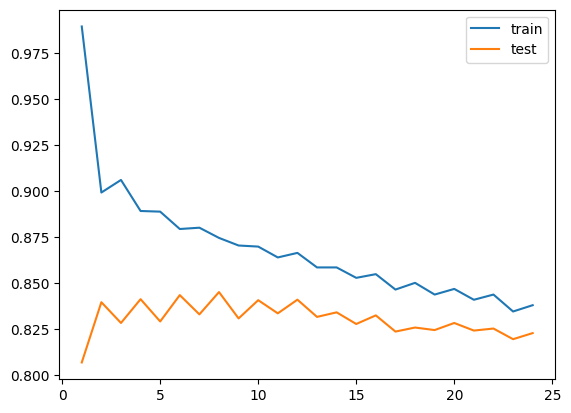

In [68]:
#b) KNN
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

train_accuracy = []
test_accuracy = []
neighoursRange = range(1,25)
for i in neighoursRange:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    train_accuracy.append(knn.score(X_train, y_train))
    test_accuracy.append(knn.score(X_test, y_test))

plt.plot(neighoursRange, train_accuracy, label='train')
plt.plot(neighoursRange, test_accuracy, label='test')
plt.legend()
plt.show()


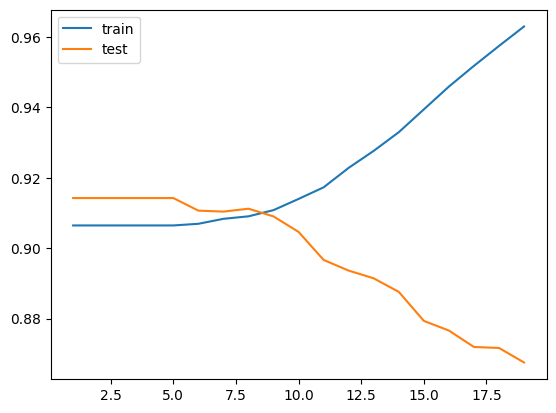

In [69]:
#c) Decision Tree
from sklearn.tree import DecisionTreeClassifier

#plot a chart to find the best max_depth
train_accuracy = []
test_accuracy = []
depthRange = range(1,20)
for n in depthRange:
    tree = DecisionTreeClassifier(max_depth=n)
    tree.fit(X_train, y_train)
    train_accuracy.append(tree.score(X_train, y_train))
    test_accuracy.append(tree.score(X_test, y_test))

plt.plot(depthRange, train_accuracy, label='train')
plt.plot(depthRange, test_accuracy, label='test')
plt.legend()


## 15. Conclusion ##
We preprocesed and analayzed the data and found that:
    the price of the listings is mostly concentrated around 1000-2000 DKK
    ...

eventually we created models to predict whether a listing is expensive or affordable and found that:
# a) Naive Bayes: #
* this model has an accuracy of 0.85-0.90, which can vary rapidly depending on the selection of features and the train/test split
# b) KNN: #
* this model's accuracy is changing between 0.81-0.84 depending on the number of neighbors with the best accuracy being at k = [5-10]
# c) Decision Tree: #
* this model has an accuracy of 0.90-0.92, which can vary rapidly depending on the max_depth and the train/test split. The best accuracy is at max_depth = [1-5] reaching accuracy of 0.915 and then it starts overfitting/declining.
